# $$ Sarsa (\lambda)$$

## Imports

In [1]:
# importsfrom libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os

# imports from project
from utils.plotting import plot_line_graphs_overlayed

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"result_graphs","SARSA_LAMBDA")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\result_graphs\\SARSA_LAMBDA'

Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-random-10x10-plus-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
LAMBDA_VAL = 0
MIN_EXPLORE_RATE = 0.001
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
DEBUG_MODE = 0
RENDER_MAZE = False
ENABLE_RECORDING = False


'''
Begin simulation
'''
#recording_folder = "/tmp/maze_q_learning"

if ENABLE_RECORDING:
    #env.monitor.start(recording_folder, force=True)
    env = gym.wrappers.Monitor(env, "recording", force=True)
    
    

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [4]:
def simulate(discount_factor:float=0.99,
            eligibility_decay:float=0.3,
            epsilon:float= 1,
            epsilon_decay:float= 0.999,
            num_streaks:int= 0,
            trace_decay:int= 0):


    """Simulate Sarsa Algorythim .

    Args:
        discount_factor (float): gamma.
        eligibility_decay (float): .
        epsilon (float): gamma.
        epsilon_decay (float): gamma.
        num_streaks (float): How many times the problem was soved on the episode.
        trace_decay (float): gamma.


    Returns:
        (matplotlib.Axes): the axes object.
    """
    
    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    learning_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []



    #discount_factor = gamma

    # Instantiating the learning related parameters
    learning_rate = get_learning_rate(0) # alpha
    explore_rate = get_explore_rate(0)
     
    # Render tha maze
    env.render()
    
    #q_table # inicializar ela aqui.
    q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)
    

    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

 
        # Reset the environment
        obv = env.reset()
        
        # initialize Reward
        total_reward = 0
        
        # initialize episolon decay
        epsilon *= epsilon_decay

        # E(S,A) = 0
        E = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)
        
        # Initialize state
        state = state_to_bucket(obv)
        
        # initialize action    # VERIFICAR SE SEGUE A POLITICA   
        action = select_action(state, explore_rate, q_table)
        
        for t in range(MAX_T):

            # Select an action
            next_action = select_action(state, explore_rate, q_table)
            
            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            next_state = state_to_bucket(obv)
            total_reward += reward
            
            # current_q
            current_q = q_table[state + (action,)] 
            
            # next_q
            next_q = q_table[next_state + (next_action,)]
            
            # TD - r + gamma * Q(S', A') - Q(S,A)
            TD = reward + (discount_factor * (next_q) - current_q )
            
            # E(S,A) - E(S,A) + 1
            E[state + (action,)] += 1
            
            #For all s E S, a E A(s)
            
            # aux_1
            aux_1 = learning_rate * TD * E
            
            # Q(S,A) - Q(S,A) + alpha * lamb * E
            q_table += aux_1
            
            
            # E(S, A) -  gama * trace_decay * E * delta * E(S,A)
            # delta = TD
            
            E = discount_factor * trace_decay * E
            
            #S - S'
            state = next_state
            
            # A - A'
            action = next_action
            
            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (episode, t, total_reward, num_streaks))

                num_streaks_copy = num_streaks
                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (episode, t, total_reward))

        

        
        reward_episode_list.append(action)
        explore_rate_episode_list.append(explore_rate)
        learning_rate_episode_list.append(learning_rate)
        num_streaks_episode_list.append(num_streaks_copy)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)

    
    print("FINAL ACTION TABLE \n")
    acts = ["N", "S", "E", "W"]
    for i in range(q_table.shape[2]):
        print(f"Action {acts[i]} table \n {q_table[:,:,i]}\n")

    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(learning_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))

## Epsilon Greed Exploration

In [5]:
def select_action(state, explore_rate, q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

In [7]:
def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## ?????

In [8]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

In [9]:
reward_episode_array,explore_rate_episode_array,learning_rate_episode_array,num_streaks_episode_array,length_episode_array = \
simulate(discount_factor=0.99,
        eligibility_decay=0.3,
        epsilon=1,
        epsilon_decay= 0.999,
        num_streaks= 0,
        trace_decay=LAMBDA_VAL)

                                                                                                    
if ENABLE_RECORDING:
    #env.monitor.close()
    env.close()


Episode 350 finished after 30.000000 time steps with total reward = 0.970000 (streak 24).
Episode 351 finished after 30.000000 time steps with total reward = 0.970000 (streak 25).
Episode 352 finished after 30.000000 time steps with total reward = 0.970000 (streak 26).
Episode 353 finished after 30.000000 time steps with total reward = 0.970000 (streak 27).
Episode 354 finished after 30.000000 time steps with total reward = 0.970000 (streak 28).
Episode 355 finished after 30.000000 time steps with total reward = 0.970000 (streak 29).
Episode 356 finished after 30.000000 time steps with total reward = 0.970000 (streak 30).
Episode 357 finished after 30.000000 time steps with total reward = 0.970000 (streak 31).
Episode 358 finished after 30.000000 time steps with total reward = 0.970000 (streak 32).
Episode 359 finished after 30.000000 time steps with total reward = 0.970000 (streak 33).
Episode 360 finished after 30.000000 time steps with total reward = 0.970000 (streak 34).
Episode 3

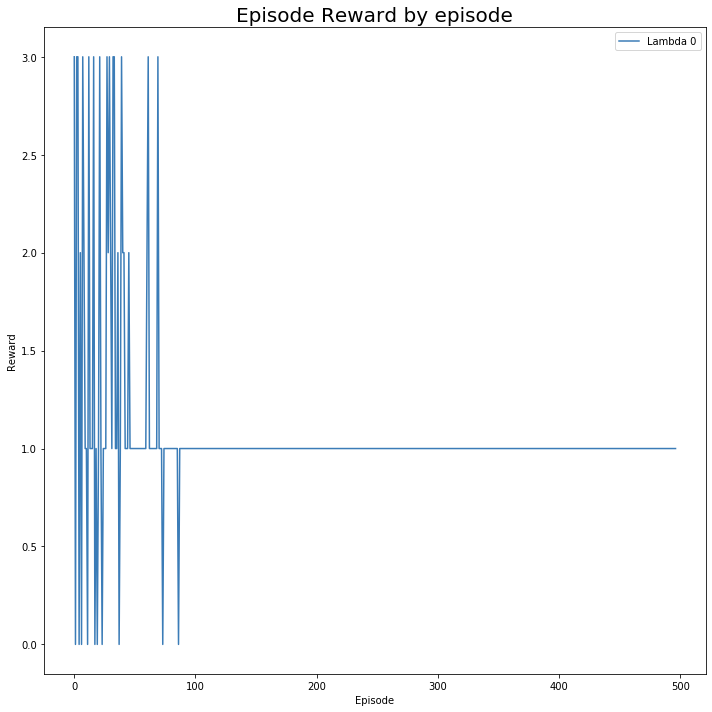

module 'matplotlib.pyplot' has no attribute 'write_image'


<Figure size 432x288 with 0 Axes>

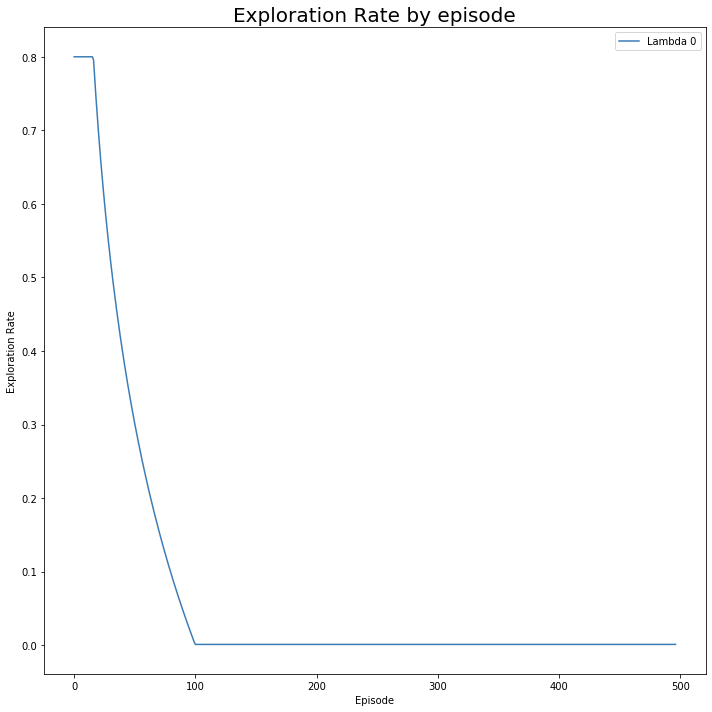

module 'matplotlib.pyplot' has no attribute 'write_image'


<Figure size 432x288 with 0 Axes>

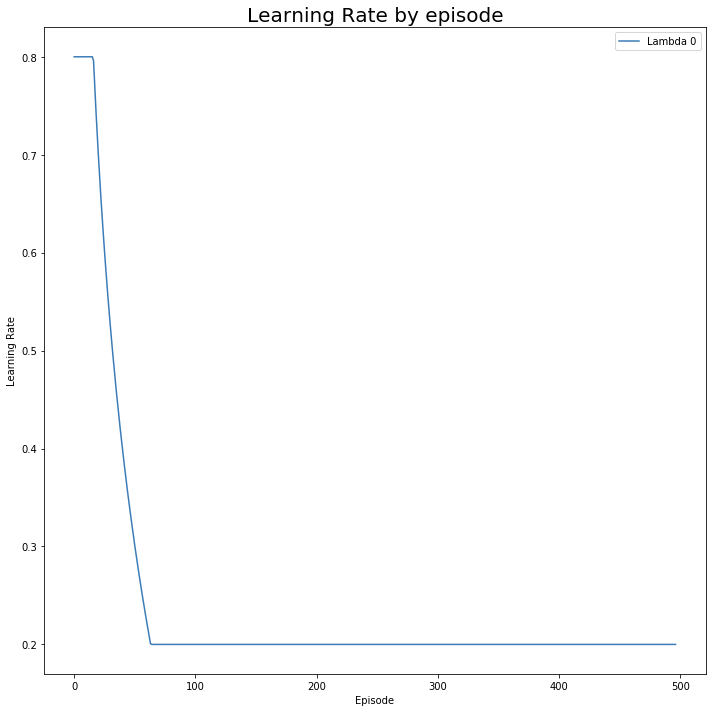

module 'matplotlib.pyplot' has no attribute 'write_image'


<Figure size 432x288 with 0 Axes>

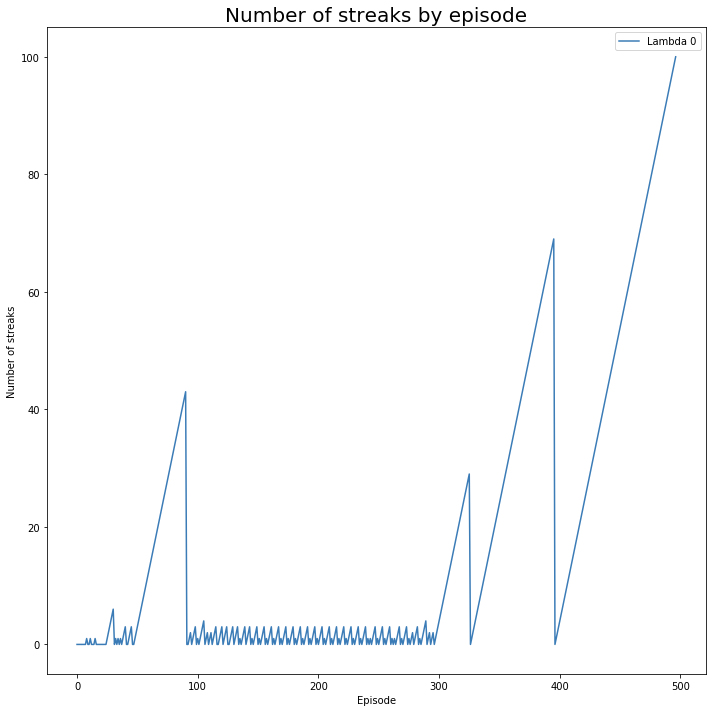

module 'matplotlib.pyplot' has no attribute 'write_image'


<Figure size 432x288 with 0 Axes>

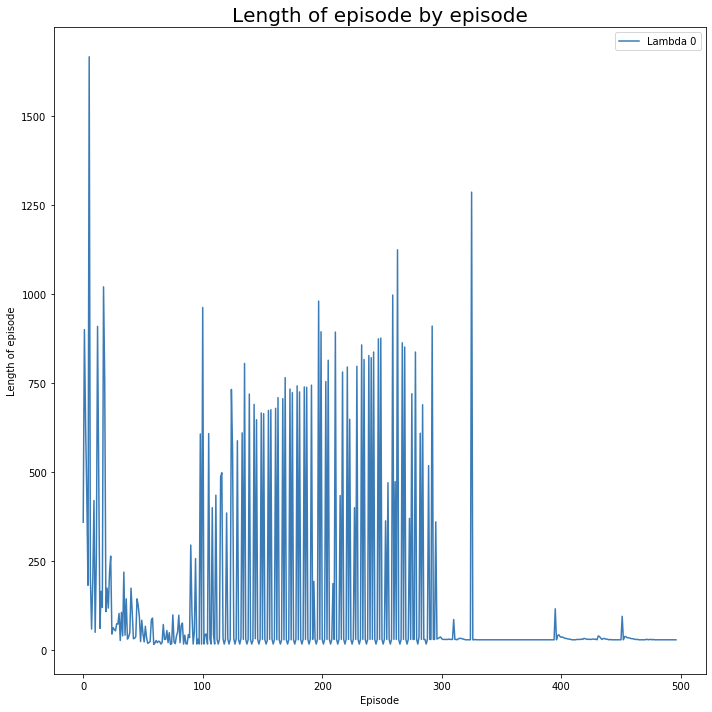

module 'matplotlib.pyplot' has no attribute 'write_image'


<Figure size 432x288 with 0 Axes>

In [10]:
 
graph_saving_path = os.path.join(SAVING_RESULTS_FODLER,"reward_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = [f"Lambda {LAMBDA_VAL}"],
                            title = "Episode Reward by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_FODLER,"explore_rate_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [explore_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Exploration Rate",
                            legends = [f"Lambda {LAMBDA_VAL}"],
                            title = "Exploration Rate by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_FODLER,"learning_rate_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [learning_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Learning Rate",
                            legends = [f"Lambda {LAMBDA_VAL}"],
                            title = "Learning Rate by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_FODLER,"num_streaks_episode_array")
plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [num_streaks_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Number of streaks",
                            legends = [f"Lambda {LAMBDA_VAL}"],
                            title = "Number of streaks by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_FODLER,"length_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [length_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Length of episode",
                            legends = [f"Lambda {LAMBDA_VAL}"],
                            title = "Length of episode by episode" ,
                            graph_saving_path = graph_saving_path)